# Neural problems via GENOT (advanced)

This example shows an advanced neural problems usage, e.g., the {class}`~moscot.problems.generic.GENOTLinProblem`.

In [1]:
%load_ext autoreload
%autoreload 2
from moscot.problems import GENOTLinProblem
from moscot import datasets
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from anndata import AnnData
import numpy as np

## Data Setup

First we set up some data from 3 different normal distributions

/var/folders/k9/9wc7lvwj2g34_r74kn6cr0nr0000gn/T/ipykernel_45096/2178879371.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(adata[adata.obs['batch'] == i].obsm['normal'].T[0], adata[adata.obs['batch'] == i].obsm['normal'].T[1], c=list(mcolors.BASE_COLORS.values())[i])


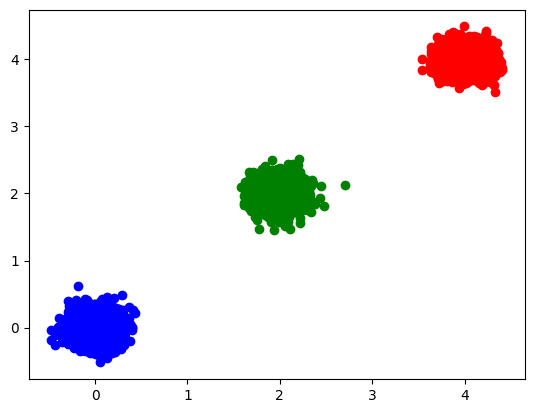

In [2]:
batches = []
n_batches = 3
n_obs_per_batch = 2048
for i in range(n_batches):
    batches += [i] * n_obs_per_batch
adata = AnnData(
    obsm = { 'normal': np.vstack([np.random.multivariate_normal([i * 2, i * 2], [[.02,0],[0,.02]], n_obs_per_batch) for i in range(n_batches)]) },
    obs = { 'batch': batches }
)

for i in range(n_batches):
    plt.scatter(adata[adata.obs['batch'] == i].obsm['normal'].T[0], adata[adata.obs['batch'] == i].obsm['normal'].T[1], c=list(mcolors.BASE_COLORS.values())[i])

## Problem Setup

Next, we set up a problem with a star policy mapping to 0 from both 1 and 2, and then train this problem _jointly_!

In [3]:
import os


problem = GENOTLinProblem(adata)
problem = problem.prepare(policy="star", reference=0, key="batch", joint_attr="normal", conditional_attr={"attr": "obs", "key": "batch"})
problem = problem.solve(batch_size=128,iterations=20000 if not (os.environ.get('CI', "false") == "true") else 1, train_size=1.0,  velocity_field_hidden_dims=[512, 512, 512],velocity_field_time_dims=[1024, 1024, 1024], velocity_field_output_dims=[1024, 1024, 1024])

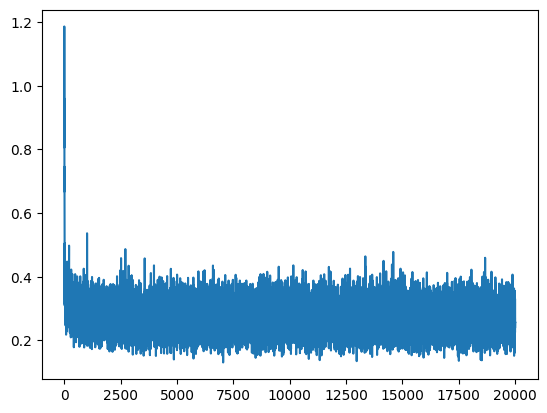

In [4]:
plt.plot(problem.solution.logs['loss'])

## Results

Finally, we can visualize the results and see that the source indeed maps to both targets rather cleanly.

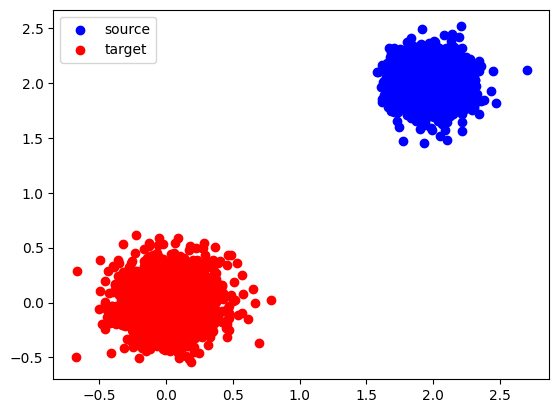

In [15]:
adata_subset = adata[adata.obs['batch'] == 1, :]
pushed = problem.solution.push(adata_subset.obsm['normal'], adata_subset.obs['batch'].values.reshape(adata_subset.shape[0], -1))
plt.scatter(adata_subset.obsm['normal'].T[0], adata_subset.obsm['normal'].T[1], c="b", label="source")
plt.scatter(pushed.T[0], pushed.T[1], c='r', label="target")
plt.legend()

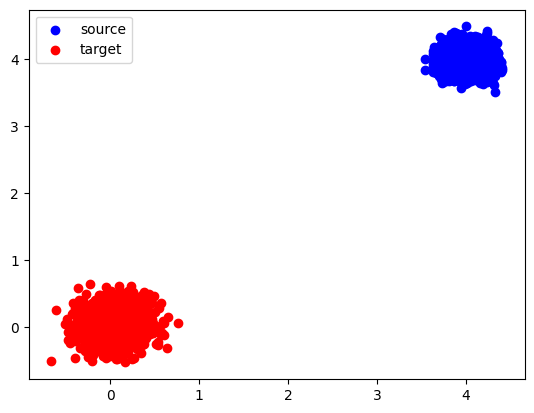

In [16]:
adata_subset = adata[adata.obs['batch'] == 2, :]
pushed = problem.solution.push(adata_subset.obsm['normal'], adata_subset.obs['batch'].values.reshape(adata_subset.shape[0], -1))
plt.scatter(adata_subset.obsm['normal'].T[0], adata_subset.obsm['normal'].T[1], c="b", label="source")
plt.scatter(pushed.T[0], pushed.T[1], c='r', label="target")
plt.legend()